In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.optimize import minimize, NonlinearConstraint, LinearConstraint
import pickle

In [2]:
def arccosh(x):
    if x < 1:
        x = 1 + np.abs(x)
    return np.arccosh(x)

In [4]:
def hyperboloid_to_ball(X):
    x0 = X[:,0]
    newX = []
    for i in range(X.shape[0]):
        newX.append(X[i]/(1+x0[i]))
    
    newX = np.array(newX)
    return newX

In [5]:
def ball_to_hyperboloid(X):
    dim = X.shape[1]
    N = X.shape[0]
    hyp = []
    for ix in range(X.shape[0]):
        hyp.append(list())
        v = X[ix]
        l2 = np.linalg.norm(v,2)
        hyp[ix].append(np.sqrt(1 + l2**2)/(1-l2**2))
        
        for jx,x in enumerate(X[ix]):
            hyp[ix].append(2*x/(1-l2**2))
    hyp = np.asarray(hyp)
    return hyp

# def ball_to_hyperboloid(X):
#     dim = X.shape[1]
#     N = X.shape[0]
#     hyp = np.zeros((N,dim))
#     l2 = np.linalg.norm(X,2, axis=1)
#     hyp[:,0] = np.sqrt(1 + l2**2)
#     hyp[:, 1:] = X[:, 1:]
#     return hyp

In [6]:
def obj(gamma, w, dim='2d'):
    p1 = np.zeros(gamma.shape[0])
    p2 = gamma
    
    d = lambda p3 : np.abs(np.linalg.norm(np.array([np.cross(p2-p1,p1-p3)]),2))/np.linalg.norm(p2-p1,2)
    f = (1/4)*np.sum([arccosh(1 + d(w_i)**2)**2 for w_i in w])
    return f


In [7]:
def isometry_map(X, fmean):
    rho = lambda v: arccosh(v[0])
    alpha = lambda jx,v: np.sinh(rho(v))/v[jx]
    dim = X.shape[1]
    N = X.shape[0]
    
    y = np.zeros((N,dim))
    y[0,:] = np.cosh(rho(X[0,:]) - rho(fmean))
    for ix in range(1,N):
        v = X[ix]
        for jx in range(len(v)):
            y[ix,jx] = alpha(jx,v)*np.sinh(rho(v)-rho(fmean))
    return y

In [8]:
def find_mean(points):
    dim = points.shape[1]
    Q = np.zeros((dim,dim))
    Q[0,0] = 1
    for i in range(1,dim):
        Q[i,i] = -1
    dL = lambda x,y: arccosh((x.T).dot(Q).dot(y)) # stability
    phi = lambda z, points: np.sum([np.sinh(dL(z,p))**2 for p in points])
    
    z0 = np.array([1,1,1])
    opt = {}
    opt['disp'] = True
    mean = minimize(phi, z0, args=(points),tol=1e-6, options=opt).x
    print('Found Mean')
    return mean
    

In [9]:
def PGA(points):
    points_hyp = ball_to_hyperboloid(points)
    fmean = find_mean(points_hyp)
    points_hyp_centered = isometry_map(points, fmean)
    points_ball_centered = hyperboloid_to_ball(points_hyp_centered)
    
    
    X = points_ball_centered
    w = np.zeros(X.shape)
    for ix in range(X.shape[0]):
        w[ix] = np.sqrt(8)*X[ix]/(1-np.linalg.norm(X[ix],2))
    # phi in range [0,pi]
    
#   Code is given as proof of concept for 2D
#   however this is how it would be parametrized for 3D
#     if dim == '3d': 
#         rads = np.deg2rad(np.random.rand(2)*180)
#         gamma0 = [np.cos(rads[0])*np.sin(rads[1]), 
#                  np.sin(rads[0])*np.cos(rads[1]),
#                  np.cos(rads[1])]
#     elif dim == '2d':
    rad = np.deg2rad(np.random.rand(1)*180)
    gamma0 = [np.cos(rad), 
             np.sin(rad)]
    gamma0 = np.array([x[0] for x in gamma0])
    
    # and we do it for PG1 and PG2
    pg1 = minimize(obj, gamma0, args=(w), tol=1e-11).x
    con = lambda gamma: np.dot(gamma, pg1) 
    nlc1 = NonlinearConstraint(con, 0, 0)
    opt = {}
    opt['disp'] = True
    pg2 = minimize(obj, gamma0, args=(w), constraints = (nlc1), tol=1e-11, options=opt).x
    return pg1, pg2, fmean

In [10]:
# Sample generated with sampling code on  https://github.com/lateral/frechet-mean-hyperboloid
with open('sample.pkl', 'rb') as f:
    ppoints = pickle.load(f)

pg1, pg2, fmean = PGA(ppoints,'2d')
print(pg1, pg2, np.dot(pg1, pg2))

         Current function value: 0.000084
         Iterations: 26
         Function evaluations: 413
         Gradient evaluations: 102
Found Mean
[-4.29156971  2.89183681]
Optimization terminated successfully    (Exit mode 0)
            Current function value: 67.58389305357818
            Iterations: 3
            Function evaluations: 9
            Gradient evaluations: 3
[-4.29156971  2.89183681] [-0.50978785 -0.75653995] 1.509903313490213e-14


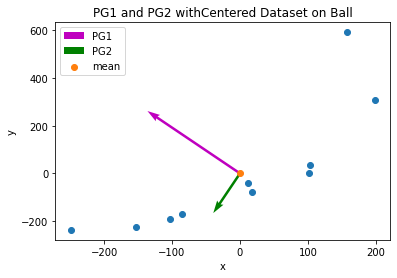

In [13]:
mn = np.mean(ppoints, axis=0)
pg1 = pg1/np.abs(np.linalg.norm(pg1))
pg2 = pg2/np.abs(np.linalg.norm(pg2))
plt.quiver(*pg1, scale=3, color=['m'], label = 'PG1')
plt.quiver(*pg2,scale=7, color=['g'], label='PG2')
plt.scatter(ppoints[:,0] - mn[0], ppoints[:,1] - mn[1])
plt.scatter(fmean[0], fmean[1], label='mean')
plt.title('PG1 and PG2 withCentered Dataset on Ball')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()